Code for investigating gene and sample clusters

In [1]:
%matplotlib inline
import bnpy
import collections
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, cophenet, linkage, dendrogram
from scipy.spatial.distance import pdist;

In [8]:
gene_set = "LYONS_IMMUNE_LANDSCAPE"
pth = os.path.abspath(".")
   
hmodel = bnpy.ioutil.ModelReader.load_model_at_prefix(pth,
                                                      prefix="LYONS_IMMUNE_LANDSCAPE")
                                                          
means = []
for comp in range(len(hmodel.allocModel.get_active_comp_probs())):
    m = hmodel.obsModel.get_mean_for_comp(comp)
    means.append(m)
    
if len(means) == 1:
    raise ValueError("Only one component was identified!")
    
pth = os.path.join(os.path.abspath('.'), 'expression.tsv')
exp = pd.read_csv(pth, sep='\t', index_col=0)
exp.head()
       
mean_df  = pd.DataFrame(data=np.vstack(means).T,
                        index=exp.index.values, 
                        columns=['cluster_%d' % c for c in range(len(means))])
                        
method = 'ward'
metric = 'euclidean'

zscore_df = mean_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1) 

row_linkage = hierarchy.linkage(
    distance.pdist(zscore_df.values), 
    method=method, metric=metric)

col_linkage = hierarchy.linkage(
    distance.pdist(zscore_df.values.T), 
    method=method, metric=metric);

In [3]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata;


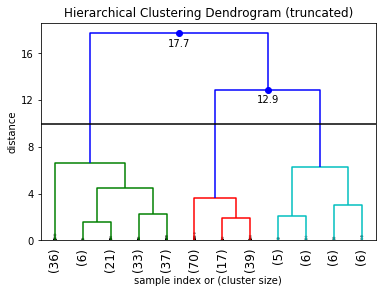

In [4]:
dist = 10

fancy_dendrogram(
    row_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=dist,
)
plt.show()

rclusters = fcluster(row_linkage, dist, criterion='distance')

rcmap = sns.color_palette("Set2", max(rclusters))

rcolors = [rcmap[i-1] for i in rclusters]

row_groups = collections.defaultdict(list)
for gene, cluster in zip(zscore_df.index, rclusters):
    row_groups[cluster].append(gene);

(282, 3)


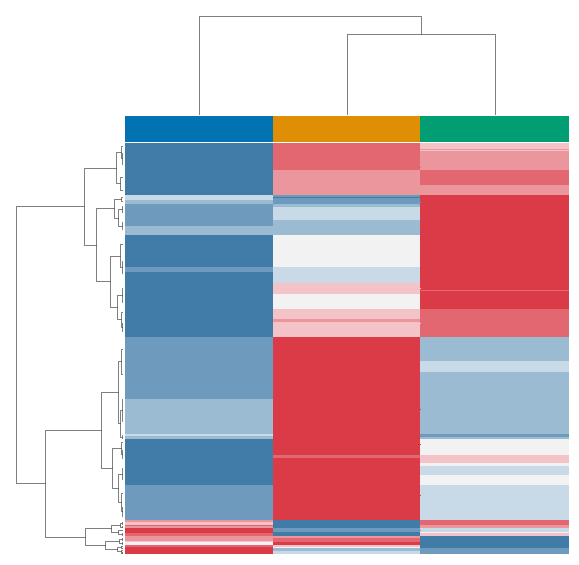

In [49]:
cmap = sns.diverging_palette(240, 10, n=9)
col_map = sns.color_palette('colorblind', 3)
print(zscore_df.shape)
g = sns.clustermap(zscore_df,
                   col_colors=[col_map[x] for x in range(3)],
                   col_linkage=col_linkage,
                   row_linkage=row_linkage,
                   #row_colors=rcolors,
                   cmap=cmap)

g.cax.set_visible(False)

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

pth = '../img/generic-mean-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

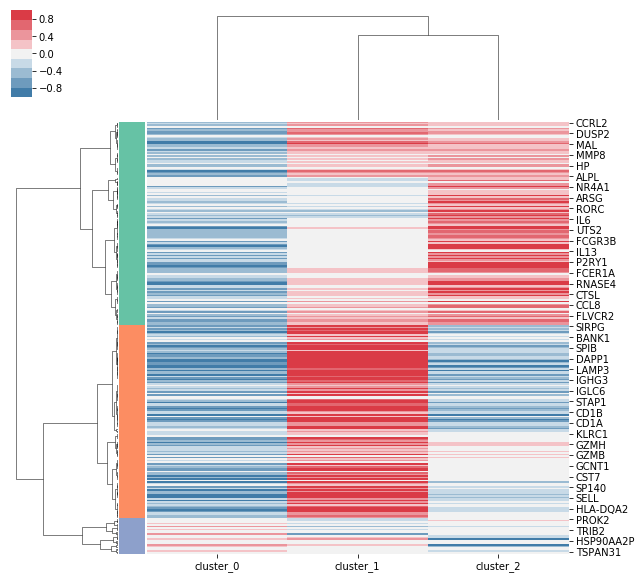

In [6]:
cmap = sns.diverging_palette(240, 10, n=9)

sns.clustermap(mean_df,
               col_linkage=col_linkage,
               row_linkage=row_linkage,
               row_colors=rcolors,
               cmap=cmap,
               vmin=-1,
               vmax=1);

In [14]:
assignments = pd.read_csv('assignments.tsv', sep='\t', header=None, index_col=0)
assignments.sort_values(1, inplace=True)

In [37]:
exp

,TARGET-30-PAPZYP-01A-01R,TARGET-30-PASWFB-01A-01R,TARGET-30-PATINJ-01A-01R,TARGET-30-PATYIL-02A-01R,TARGET-30-PARZCJ-01A-01R,TARGET-30-PASNZU-01A-01R,TARGET-30-PASHFA-01A-01R,TARGET-30-PATAYJ-01A-01R,TARGET-30-PAPBGH-01A-01R,TARGET-30-PARFWB-01A-01R,...,TARGET-30-PASXHE-01A-01R,TARGET-30-PAIPGU-01A-01R,TARGET-30-PASXIE-01A-01R,TARGET-30-PASDZJ-01A-01R,TARGET-30-PASFRV-01A-01R,TARGET-30-PASGPY-01A-01R,TARGET-30-PASLGS-01A-01R,TARGET-30-PASCLP-01A-01R,TARGET-30-PARRBU-01A-01R,TARGET-30-PARSHT-01A-01R
hugo,,,,,,,,,,,,,,,,,,,,,
SSPN,1.735522,1.275007,1.157044,1.879706,2.028569,1.316146,1.298658,1.659925,1.811471,1.035624,...,1.250962,1.014355,1.090853,2.990955,2.266037,2.350497,1.875780,1.250962,1.304511,2.063503
CD38,0.978196,0.344828,1.056584,1.744161,2.304511,0.201634,1.372952,1.541019,0.485427,1.555816,...,1.608809,1.485427,0.201634,6.189232,3.381283,1.232661,2.169925,0.124328,0.176323,1.459432
ELANE,0.985500,0.028569,0.150560,0.000000,0.137504,0.028569,0.000000,0.150560,0.028569,0.056584,...,0.028569,0.575312,0.000000,1.117695,0.070389,0.000000,0.056584,0.000000,0.000000,0.056584
HSPA6,2.682573,3.973611,0.925999,0.356144,3.351911,3.204767,1.361768,0.422233,0.831877,3.399171,...,2.541019,1.735522,0.356144,1.722466,0.823749,0.238787,1.432959,2.084064,4.941106,0.918386
HSPA5,6.389050,6.282625,7.410494,6.631541,6.515542,5.480911,5.914804,6.072535,6.460906,7.103917,...,6.051372,6.300124,5.222650,6.938639,6.184479,5.613237,6.167117,5.473137,7.824959,5.876026
FLVCR2,1.232661,0.782409,1.056584,1.350497,3.016140,0.344828,0.687061,1.021480,0.594549,1.333424,...,1.220330,0.992768,0.389567,1.974529,1.378512,0.659925,0.895303,0.150560,0.310340,0.575312
TBX21,0.367371,0.097611,0.238787,0.056584,0.422233,0.137504,0.378512,0.432959,0.000000,0.344828,...,0.495695,0.495695,0.124328,2.053111,0.695994,0.275007,0.214125,0.000000,0.070389,0.378512
RP11-295K3.1,0.678072,0.782409,1.469886,1.090853,1.035624,0.505891,0.163499,0.250962,0.847997,1.111031,...,0.298658,1.035624,0.000000,0.214125,0.150560,0.748461,0.000000,0.111031,0.941106,0.505891
SPRED1,2.526069,2.028569,1.875780,2.575312,2.918386,2.353323,1.599318,2.467279,2.241840,1.803227,...,2.117695,2.330558,2.577731,2.488001,3.046142,2.831877,2.901108,2.752749,2.386811,2.648465


In [44]:
pth = '../maris-exp-log2TPM1-2018-07-19.tsv'
start = pd.read_csv(pth, sep='\t', index_col=0)
start = start.reindex(exp.columns, axis=1)

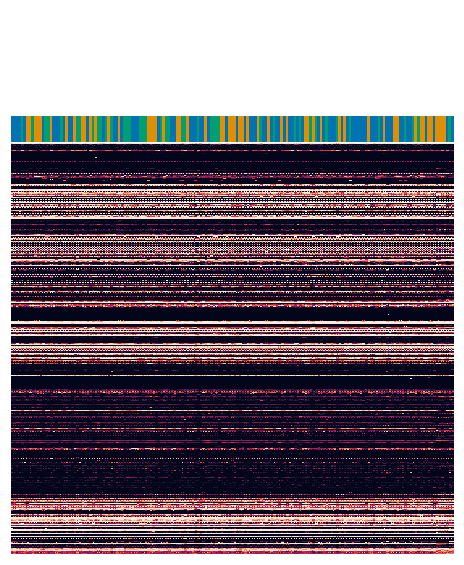

In [46]:
cmap = sns.color_palette('colorblind', 3)
c0 = [cmap[assignments.loc[x, 1]] for x in start.columns]
g = sns.clustermap(start,
                   col_colors=c0,
                   col_cluster=False,
                   row_cluster=False,
                   vmax=4)

ax = g.ax_heatmap

g.cax.set_visible(False)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('')

g.ax_row_dendrogram.set_visible(False)

pth = '../img/pre-cluster-generic-pan-sample-all-genes-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

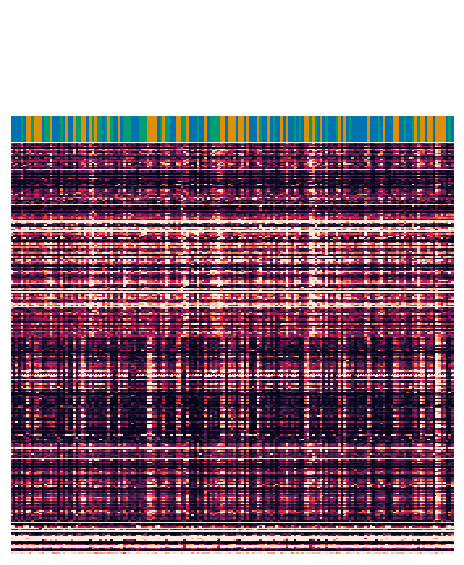

In [30]:
cmap = {0: '#2f74a2', 1:'#e28228', 2:'#379337'}
cmap = sns.color_palette('colorblind', 3)
c1 = [cmap[assignments.loc[x, 1]] for x in exp.columns]
g = sns.clustermap(exp,
                   col_colors=c1,
                   col_cluster=False,
                   row_linkage=row_linkage,
                   vmax=4)

ax = g.ax_heatmap

g.cax.set_visible(False)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('')

g.ax_row_dendrogram.set_visible(False)

pth = '../img/pre-cluster-generic-pan-sample-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [34]:
assignments[1].values


0
TARGET-30-PAPZYP-01A-01R    0
TARGET-30-PARJVP-01A-01R    0
TARGET-30-PANRHJ-01A-01R    0
TARGET-30-PAPBZI-01A-01R    0
TARGET-30-PARBAJ-01A-01R    0
TARGET-30-PAPICY-01A-01R    0
TARGET-30-PASXRG-01A-01R    0
TARGET-30-PASVRU-01A-01R    0
TARGET-30-PASUYG-01A-01R    0
TARGET-30-PASMNT-01A-01R    0
TARGET-30-PATFXV-01A-01R    0
TARGET-30-PASNPG-01A-01R    0
TARGET-30-PARHAM-01A-01R    0
TARGET-30-PAMNLH-01A-01R    0
TARGET-30-PATNKP-02A-01R    0
TARGET-30-PALNVP-01A-01R    0
TARGET-30-PAKZRH-01A-01R    0
TARGET-30-PANWRR-01A-01R    0
TARGET-30-PASZKE-01A-01R    0
TARGET-30-PAMZMG-01A-01R    0
TARGET-30-PAPVEB-04A-01R    0
TARGET-30-PASUCB-01A-01R    0
TARGET-30-PASPBZ-01A-01R    0
TARGET-30-PANBJH-01A-01R    0
TARGET-30-PAIFXV-01A-01R    0
TARGET-30-PANYGR-01A-01R    0
TARGET-30-PASSWW-01A-01R    0
TARGET-30-PANZPV-01A-01R    0
TARGET-30-PASCLP-01A-01R    0
TARGET-30-PASXIE-01A-01R    0
                           ..
TARGET-30-PAPTCR-01A-01R    2
TARGET-30-PAPLSD-01A-01R    2
TARGET-3

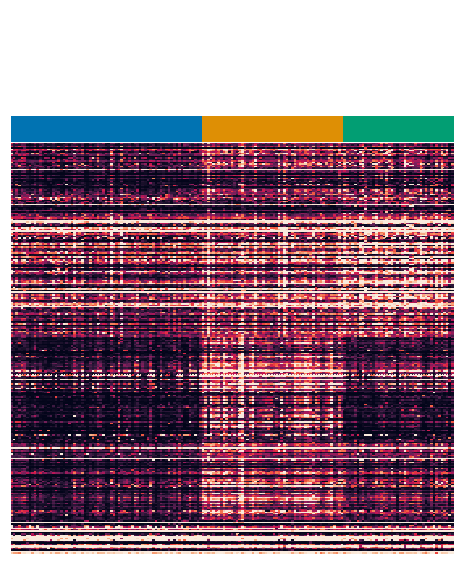

In [36]:
c2 = [cmap[assignments.loc[x, 1]] for x in assignments.index.values]
g = sns.clustermap(exp[assignments.index.values],
                   col_colors=c2,
                   col_cluster=False,
                   row_linkage=row_linkage,
                   #row_colors=rcolors,
                   vmax=4)

g.cax.set_visible(False)

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('')

g.ax_row_dendrogram.set_visible(False)
pth = '../img/generic-pan-sample-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [13]:
print "\n".join(row_groups[1]);

SSPN
ELANE
HSPA6
HSPA5
FLVCR2
RP11-295K3.1
SPRED1
FCGR1B
FCGR1A
S100A12
MS4A2
MS4A3
MRC1
MAP3K8
AMZ1
DHRS9
GADD45B
RORC
OSM
CRISPLD2
CTSL
RNASE4
FPR1
OASL
CCRL2
CTSG
SOCS3
CXCL8
SLC2A5
IGLL3P
SLC2A3
SLC2A1
AZU1
SOD2
PTGS1
TLR7
CD300C
CHAC1
MAL
CCL8
NFKBIZ
MGST1
TRIB1
IFIT3
IFIT2
IL1R2
TLR2
DDX58
MARCO
EGR2
MT1M
MT1H
HPR
MT1E
MT1F
MT1G
H19
USP18
IFIT1B
INSIG1
CYP1B1
CP
ZBTB16
MPO
DDR1
PRDM1
SLC22A3
EPHX1
HERC6
VDR
ADCYAP1
CTH
HPGD
FGFRL1
FCER1A
FZD5
S1PR3
CD83
ST6GALNAC2
NR4A3
S100A9
RPPH1
ART1
DUSP5
ASGR2
ANG
MCEMP1
SEMA3C
F5
HP
IL10
DUSP2
IL13
IL6
ADRB2
RIPK2
ABCA1
LCN2
BPI
FCGR3B
F13A1
TMEM158
ALDH1A1
S100B
KYNU
CAMP
FBP1
RSAD2
DEFA4
DEFA3
IFIT1
FCGBP
UTS2
ANXA4
CEBPB
CD44
NR4A1
FCGR2B
FCGR2C
LYPD2
PLA2G4A
P2RY1
ARSG
CLEC4D
CFB
PON3
PALM2-AKAP2
HCAR3
ATF3
MMP8
ATF5
ABCC3
ALPL


In [43]:
pth = '/home/jpfeil/treehouse/maris/data/atrx_TARGET.xlsx'

atrx = pd.read_excel(pth, sheetname=0, index_col=0)

In [44]:
atrx

,WES,WGS,ATRX
Sample,,,
TARGET-30-PAKZRF,1.0,NaN,Del
TARGET-30-PANZVU,1.0,NaN,Del
TARGET-30-PALNLU,1.0,NaN,Del
TARGET-30-PARKNP,1.0,NaN,Del
TARGET-30-PANXJL,1.0,NaN,Del
TARGET-30-PASAAN,1.0,NaN,Del
TARGET-30-PALFPI,1.0,NaN,Del
TARGET-30-PAILNU,1.0,NaN,Del
TARGET-30-PAMVLG,1.0,NaN,Del


In [45]:
pth = '/home/jpfeil/treehouse/hydra/neuroblastoma/maris-hydra-2018-07-23/LYONS_IMMUNE_LANDSCAPE/assignments.tsv'

asign = pd.read_csv(pth, 
                    sep='\t', 
                    header=None)

asign.columns= ['sample', 'assignment']

asign.set_index('sample', inplace=True)

for i, row in asign.iterrows():
    root = '-'.join(i.split('-')[:3])
    try:
        status = atrx.loc[root, 'ATRX']
        
    except KeyError:
        status = np.nan
        
    asign.loc[i, 'atrx'] = status

In [62]:
pth = '/home/jpfeil/write/mixture-paper/data/target-features.tsv'

features = pd.read_csv(pth, sep='\t')
features.set_index(['sample', 'feature'], inplace=True)

mycn = []
for i, row in features.loc[(features.index.get_level_values('feature') == 'MYCN Activity')].iterrows():
    if row.value == 'active':
        mycn.append("%sA-01R" % i[0])

In [91]:
asign['CD8B'] = exp.loc['CD8B']

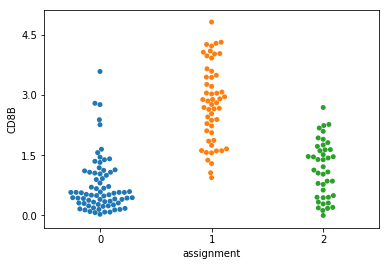

In [92]:
import seaborn as sns

sns.swarmplot(x='assignment', y='CD8B', data = asign)

In [98]:
usis = set()
mask = (asign['atrx'].isnull()) & (~asign.index.isin(mycn))
samples = []
for i , row in asign[mask].groupby('assignment'):
    _samples = []
    while len(_samples) < 5:
        sample = row.sample(1).index.values[0]
        usi = '-'.join(sample.split('-')[:3])
        if '01A' in sample and usi not in usis and usi in atrx.index:
            usis.add(usi)
            _samples.append(usi)
    samples.extend(_samples)
    
samples

['TARGET-30-PASMNT',
 'TARGET-30-PANYGR',
 'TARGET-30-PASUYG',
 'TARGET-30-PARJVP',
 'TARGET-30-PATHKB',
 'TARGET-30-PANKFE',
 'TARGET-30-PARBGP',
 'TARGET-30-PANBMJ',
 'TARGET-30-PASXHE',
 'TARGET-30-PAIVHE',
 'TARGET-30-PASTKC',
 'TARGET-30-PAPTDH',
 'TARGET-30-PARKGJ',
 'TARGET-30-PALXTB',
 'TARGET-30-PASGAP']

In [99]:
atrx

,WES,WGS,ATRX
Sample,,,
TARGET-30-PAKZRF,1.0,NaN,Del
TARGET-30-PANZVU,1.0,NaN,Del
TARGET-30-PALNLU,1.0,NaN,Del
TARGET-30-PARKNP,1.0,NaN,Del
TARGET-30-PANXJL,1.0,NaN,Del
TARGET-30-PASAAN,1.0,NaN,Del
TARGET-30-PALFPI,1.0,NaN,Del
TARGET-30-PAILNU,1.0,NaN,Del
TARGET-30-PAMVLG,1.0,NaN,Del


In [100]:
for s in samples:
    if s not in atrx.index:
        print(s)

In [101]:
atrx[(atrx['ATRX'].notnull()) | (atrx.index.isin(samples))]

,WES,WGS,ATRX
Sample,,,
TARGET-30-PAKZRF,1.0,NaN,Del
TARGET-30-PANZVU,1.0,NaN,Del
TARGET-30-PALNLU,1.0,NaN,Del
TARGET-30-PARKNP,1.0,NaN,Del
TARGET-30-PANXJL,1.0,NaN,Del
TARGET-30-PASAAN,1.0,NaN,Del
TARGET-30-PALFPI,1.0,NaN,Del
TARGET-30-PAILNU,1.0,NaN,Del
TARGET-30-PAMVLG,1.0,NaN,Del


In [102]:
pth = '/home/jpfeil/treehouse/maris/nbl-immune-subtype-samples.tsv'

atrx[(atrx['ATRX'].notnull()) | (atrx.index.isin(samples))].to_csv(pth, sep='\t')

In [107]:
atrx[(atrx['ATRX'].notnull()) | (atrx.index.isin(samples))].shape

(39, 3)

In [47]:
plot_df = pd.DataFrame(columns=['assignment', 'atrx', 'count'])

for (a, x), row in asign.groupby(['assignment', 'atrx']):
    plot_df.loc[len(plot_df), :] = [a, x, row.shape[0]]
    
plot_df

,assignment,atrx,count
0,0,Mut,2
1,1,Del,8
2,1,Mut,1
3,2,Del,1
4,2,Mut,1


In [48]:
plot_df

,assignment,atrx,count
0,0,Mut,2
1,1,Del,8
2,1,Mut,1
3,2,Del,1
4,2,Mut,1
